# Lab 1: Dynamic Time Warping

* Author: Romain Tavenard (@rtavenar)
* License: CC-BY-NC-SA

A lab session from a course on Machine Learning for Time Series at ENSAI.
One can find lecture notes for this course [there](https://rtavenar.github.io/ml4ts_ensai/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tslearn.metrics import dtw_path, soft_dtw
from tslearn.barycenters import dtw_barycenter_averaging, softdtw_barycenter
# https://tslearn.readthedocs.io/en/stable/gen_modules/barycenters/tslearn.barycenters.softdtw_barycenter.html#tslearn.barycenters.softdtw_barycenter

## Barycenters in the presence of time shifts

Let us define time series `x0` and `x1` as follows:

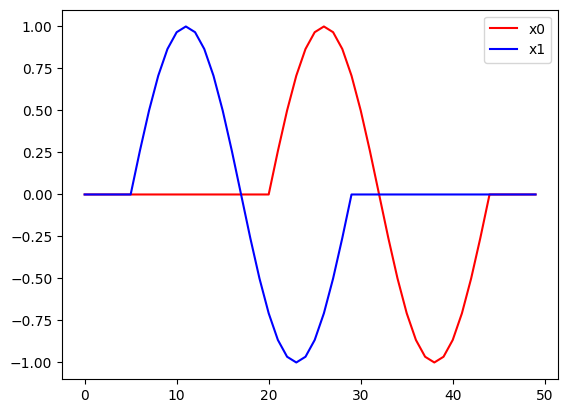

In [2]:
size = 50
x0 = np.zeros((size, ))
x0[20:20+size//2] = np.sin(np.linspace(0, 2 * np.pi, size // 2))

x1 = np.zeros((size, ))
x1[5:5+size//2] = np.sin(np.linspace(0, 2 * np.pi, size // 2))

plt.figure()
plt.plot(x0, 'r-', label='x0')  # red
plt.plot(x1, 'b-', label='x1')  # blue
plt.legend()
plt.show()

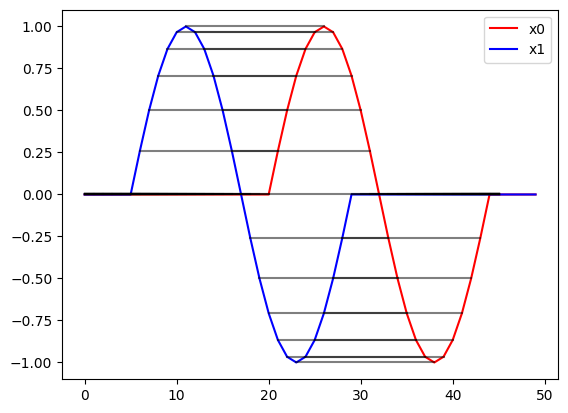

0.0


In [3]:
path, dist = dtw_path(x0, x1)

plt.figure()
plt.plot(x0, 'r-', label='x0')  # red
plt.plot(x1, 'b-', label='x1')  # blue
for i, j in path:
    plt.plot([i, j], [x0[i], x1[j]], "k-", alpha=.5)
plt.legend()
plt.show()

print(dist)

**Question #0.** Using `plt.imshow(m)` (that shows the content of a matrix `m` as an image), visualize the $A_\pi$ matrix that results from the previous time series alignment.

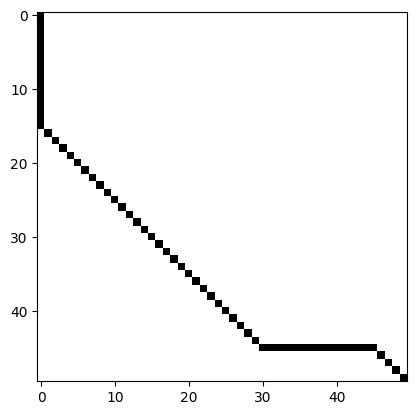

In [5]:
# 1. Define A_pi
A_pi = np.zeros((size, size), dtype=int)
for i, j in path:
    A_pi[i, j] = 1

# 2. Visualize A_pi
plt.imshow(A_pi, cmap="Greys")

**Question #1.** Compute a Euclidean barycenter of the time series `x0` and `x1` above and plot it.

In [6]:
euclidean_barycenter = (x0 + x1) / 2

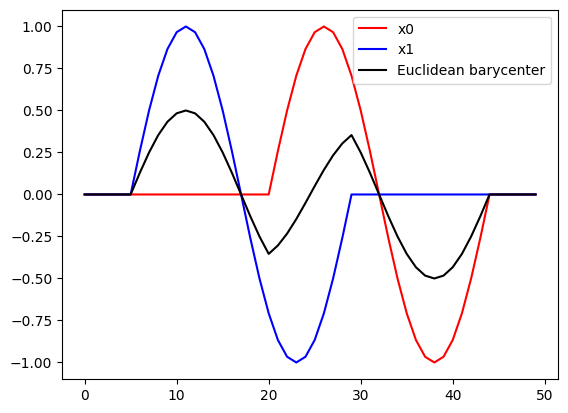

In [7]:
plt.figure()
plt.plot(x0, 'r-', label='x0')  # red
plt.plot(x1, 'b-', label='x1')  # blue
plt.plot(euclidean_barycenter, 'k-', label='Euclidean barycenter')
plt.legend()
plt.show()

**Question #2.** Repeat this experiment with a DTW barycenter (rely on [`tslearn`'s implementation](https://tslearn.readthedocs.io/en/stable/gen_modules/barycenters/tslearn.barycenters.dtw_barycenter_averaging.html#tslearn.barycenters.dtw_barycenter_averaging) for now) 
computed using the DTW Barycenter Averaging (DBA) method.

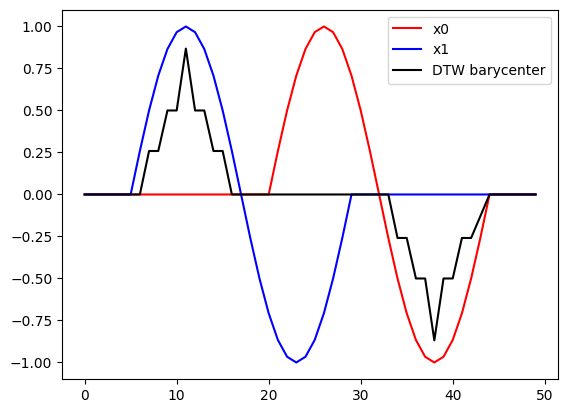

In [8]:
dtw_barycenter = dtw_barycenter_averaging([x0, x1])

plt.figure()
plt.plot(x0, 'r-', label='x0')  # red
plt.plot(x1, 'b-', label='x1')  # blue
plt.plot(dtw_barycenter[:, 0], 'k-', label='DTW barycenter')
plt.legend()
plt.show()

**Question #3.** It is likely that the observed barycenter be noisy. Use soft-DTW to smooth it out ([link to the docs of softDTW barycenter estimation in `tslearn`](https://tslearn.readthedocs.io/en/stable/gen_modules/barycenters/tslearn.barycenters.softdtw_barycenter.html#tslearn.barycenters.softdtw_barycenter)). 
Test with various values of $\gamma$ to study its influence on the obtained barycenter.
What would you say about the barycenters obtained for extreme values of $\gamma$?

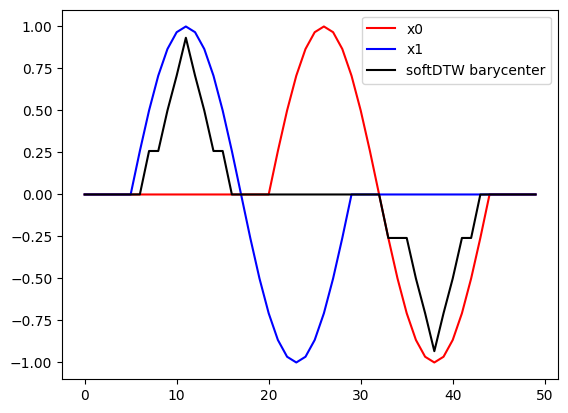

In [11]:
sdtw_barycenter = softdtw_barycenter([x0, x1], gamma=1e-6)

plt.figure()
plt.plot(x0, 'r-', label='x0')  # red
plt.plot(x1, 'b-', label='x1')  # blue
plt.plot(sdtw_barycenter[:, 0], 'k-', label='softDTW barycenter')
plt.legend()
plt.show()

## Finding a needle in a haystack (using a variant of DTW)

In the following, we will use a variant of Dynamic Time Warping in order to retrieve a snippet of the song
"Stairway to Heaven" in a 1min-long part of the song (the full song is too large to fit in memory for 
Deepnote standards).
The corresponding audio files are attached to this project, and you can play the snippets to better 
understand the task we are given:

In [16]:
import IPython.display as ipd

# The short snippet
ipd.Audio(filename='audio/StairwayToHeaven_MakesMeWonder.mp3')

In [17]:
# The 1min-long part
ipd.Audio(filename='audio/StairwayToHeaven_1min.mp3')

Let us load (pre-computed) chroma features extracted from these audio files.
Chroma features inform about the energy in spectral bands that correspond to all semitones in the 
12-tone scale.
These are hence multivariate time series of dimension 12 (one feature per semitone).

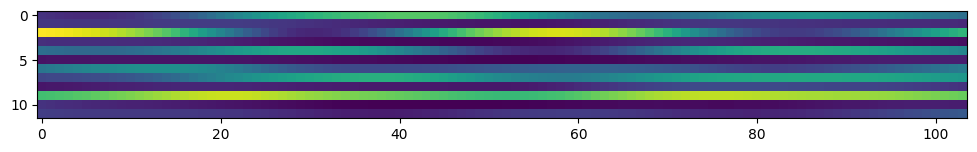

In [14]:
from utils_audio import load_chroma_features, get_subset_wav

x_short, x_long = load_chroma_features()

# View chromagram of x_short
plt.figure(figsize=(12, 6))
plt.imshow(x_short.T)
plt.show()

In [15]:
print(x_short.shape, x_long.shape)

(104, 12) (518, 12)


**Question #4.** Implement a subsequence DTW algorithm. Subsequence DTW works as follows. 
It takes both a shorter time series and a longer one as inputs and finds out the best match 
of the shorter time series in the longer one.
This means border constraints similar to that of DTW should be enforced for the shorter time
series (its first and last time index should be matched), but not for the larger one 
(it is accepted that only a subpart of this series is matched). 
Your implementation should take two time series as input and return both the score of the match
and the index in the longer time series at which this match ends.

In [18]:
from scipy.spatial.distance import cdist

def subsequence_dtw(short_seq, long_seq):
    # Compute cross distance matrix
    distances = cdist(short_seq, long_seq, "sqeuclidean")  # distances[i, j] = distance between short_seq[i] and long_seq[j]
    gamma_mat = np.zeros((len(short_seq), len(long_seq)))
    for i in range(len(short_seq)):
        for j in range(len(long_seq)):
            if i == 0:
                gamma_mat[i, j] = distances[i, j]
            elif j == 0:
                gamma_mat[i, j] = distances[i, j] + gamma_mat[i - 1, j]
            else:
                gamma_mat[i, j] = distances[i, j] + min(gamma_mat[i, j - 1],
                                                        gamma_mat[i - 1, j],
                                                        gamma_mat[i - 1, j - 1])
    idx_end_of_match = np.argmin(gamma_mat[-1])
    optimal_cost = np.sqrt(gamma_mat[-1, idx_end_of_match])
    return optimal_cost, idx_end_of_match

If your implementation has the expected signature, the following code should allow you to qualitatively 
test whether the snippet retrieved by your method matches our query

🎵 _Ooooh, it makes me wonder..._ 🎵

In [19]:
dist, idx_end = subsequence_dtw(x_short, x_long)

ipd.Audio(get_subset_wav(idx_end), rate=22050)